IN PROGRESS

TODO:
- add sympy to subcirucit classes
- add ac sim tool; try to do an inhertince from last section
- add rl complimeint filters
- create table of low-high pass vs rc & rl
- add rlc resonce
- add rlc filters
- add filter desighn tool and filter cirucit generation tool
- discues L->C passive conversion

In [1]:
#%%writefile DCtools_op.py


from skidl.pyspice import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#becouse it's written by a kiwi you know
import lcapy as kiwi

from IPython.display import YouTubeVideo, display

import traceback

#can you say cheeky 
import PySpice as pspice


#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# Basic Passive Filters

## The low pass filter from ALL ABOUT ELECTRONICS "RC Low Pass Filter Explained"  @~ 8:35min

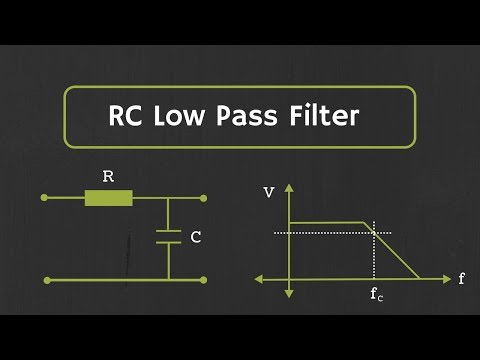

In [2]:
YouTubeVideo('_2L0l-E1Wx0', width=500, height=400, start=515)

In [3]:
class rc_lowpass():
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RC_Lowpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.c=C(value=self.C_value)
        self.r=R(value=self.R_value)
        
        self.r[1, 2]+=term_0, self.c['p']
        self.c['p', 'n']+=term_2, term_3
        
        
        
        
        if return_elements:
            return self.c, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_1; right, l=R{str(self.R_value)}')
        self.schematic.add(f'C 2_1 1_1; down, l=C{str(self.C_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

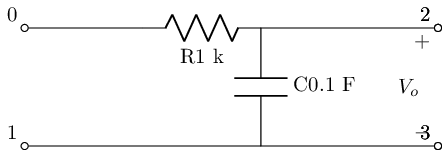

In [4]:
lowpassF=rc_lowpass(C_value=.1@u_uF, R_value=1@u_kOhm)
lowpassF.draw_me()

In [5]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(amplitude=10@u_V, frequency=2@u_kHz)
vs['p', 'n']+=net_1, gnd
lowpassF.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

.title 
C1 N2 0 0.1uF
R1 N1 N2 1kOhm
V1 N1 0 DC 0V AC 1V 0.0rad SIN(0V 10V 2kHz 0s 0Hz)




No errors or warnings found during netlist generation.



In [6]:
sim=circ.simulator()

In [7]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10, variation='dec')

In [8]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

Should be unit less


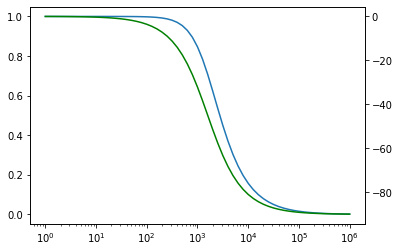

In [9]:
plt.semilogx(f, np.abs(v_o))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

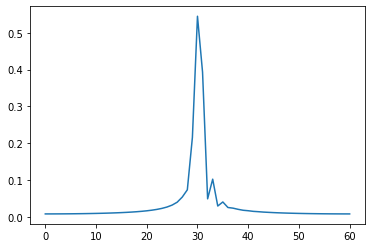

In [10]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

In [11]:
#pz_vals=sim.pole_zero(node(net_1), node(gnd), node(net_2), node(gnd), 'vol', 'pz')

## The high pass filter from ALL ABOUT ELECTRONICS "RC High Pass Filter Explained"  @~ 7:57min

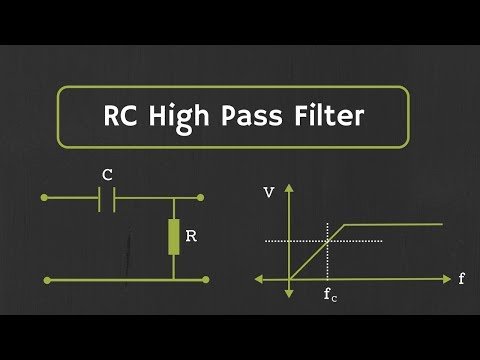

In [12]:
YouTubeVideo('9Dx0b0ukNAM', width=500, height=400, start=477)

In [13]:
class rc_highpass():
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RC_Highpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.c=C(value=self.C_value)
        self.r=R(value=self.R_value)
        
        self.c['p', 'n']+=term_0, term_2
        self.r[1, 2]+=self.c['n'], term_1
        
        
        
        
        if return_elements:
            return self.c, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'C 0_1 2_1; right, l=C{str(self.C_value)}')
        self.schematic.add(f'R 2_1 1_1; down, l=R{str(self.R_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

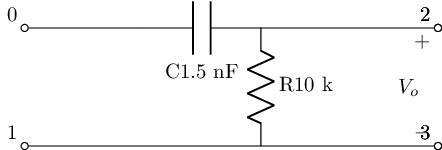

In [14]:
highpassF=rc_highpass(C_value=1.5@u_nF, R_value=10@u_kOhm)
highpassF.draw_me()

In [15]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(amplitude=10@u_V, frequency=10@u_kHz)
vs['p', 'n']+=net_1, gnd
highpassF.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

.title 
C1 N1 N2 1.5nF
R1 N2 0 10kOhm
V1 N1 0 DC 0V AC 1V 0.0rad SIN(0V 10V 10kHz 0s 0Hz)




No errors or warnings found during netlist generation.



In [16]:
sim=circ.simulator()

In [17]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10, variation='dec')

In [18]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

Should be unit less


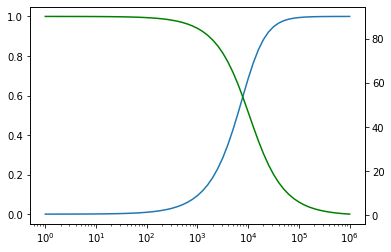

In [19]:
plt.semilogx(f, np.abs(v_o))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

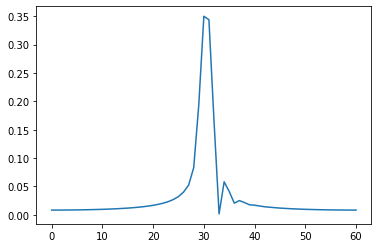

In [20]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

# Seconed Order filters

## The band pass filter from ALL ABOUT ELECTRONICS "Band Pass Filter and Band Stop Filter Explained"  @~ 4:03min

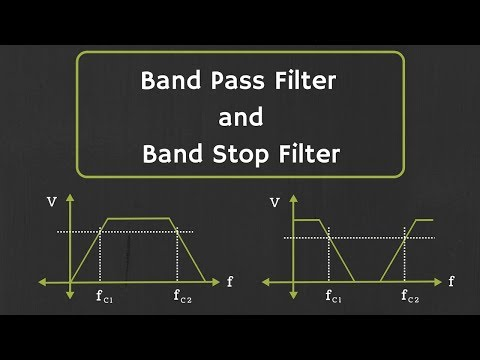

In [21]:
YouTubeVideo('dmPIydL0lyM', width=500, height=400, start=243)

## Citations:
[1] ALL ABOUT ELECTRONICS. "RC Low Pass Filter Explained," YouTube, Aug 20, 2017. [Video file]. Available: https://youtu.be/_2L0l-E1Wx0. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "RC High Pass Filter Explained," YouTube, Aug 23, 2017. [Video file]. Available: https://youtu.be/9Dx0b0ukNAM. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "Band Pass Filter and Band Stop Filter Explained," YouTube, Sep 2, 2017. [Video file]. Available: https://youtu.be/dmPIydL0lyM. [Accessed: Nov 30, 2020].
